In [1]:
import nengo
import nest
import matplotlib.pyplot as plt
from math import exp
import numpy as np
from numpy import e

**Nengo/NEST parameter correspondence (unfinished)**
![title](nengo_nest_params.png)

In [2]:
A_AMPA= 1.
A_NMDA= 0.025
A_GABA=-0.25 # mV

D_AMPA=5./exp(1)
D_NMDA=100./exp(1)
D_GABA=5./exp(1)   # ms ; /e because Dn is peak half-time in LG14, while it is supposed to be tau_peak in NEST

tau_syn = [D_AMPA, D_NMDA, D_GABA]
wPSP = [A_AMPA, A_NMDA, A_GABA]  # PSP amplitude (mV) ; A in LG14 notation

CommonParams = {'t_ref':         2.0,
                'V_m':           0.0,
                'V_th':         10.0, # dummy value to avoid NEST complaining about identical V_th and V_reset values
                'E_L':           0.0, # resting potential
                'V_reset':       0.0,
                'I_e':           0.0,
                'V_min':       -20.0, # as in HSG06
                'tau_syn':   tau_syn,}

MSNparams = {'tau_m':        13.0, # according to SBE12
             'V_th':         30.0, # value of the LG14 example model, table 9
             'C_m':          13.0,  # so that R_m=1, C_m=tau_m
             'tau_syn':tau_syn
            }


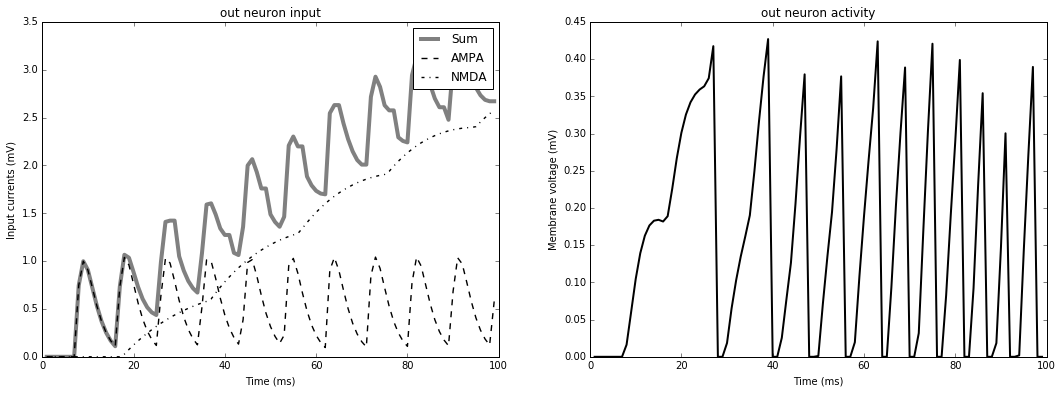

In [3]:
#Nest kernel settings
nest.ResetKernel()
msd = 1
N_vp = nest.GetKernelStatus(['total_num_virtual_procs'])[0]
nest.SetKernelStatus({"resolution": .001})
pyrngs = [np.random.RandomState(s) for s in range(msd, msd+N_vp)]
nest.SetKernelStatus({'grng_seed' : msd+N_vp})
nest.SetKernelStatus({'rng_seeds' : range(msd+N_vp+1, msd+2*N_vp+1)})

#Change LIF (iaf) default parameters
nest.SetDefaults("iaf_psc_alpha_multisynapse", CommonParams)



#create populations
AMPA_thr = 0.45
NMDA_thr = 0.87
out_thr = 0.45
AMPA_in = nest.Create("iaf_psc_alpha_multisynapse",
            params={'V_th':          AMPA_thr, 
                    'I_e':           1.5, 
                    't_ref':         2., 
                    'V_min':         0., 
                    'tau_m':         20., 
                    'C_m':           20.,
                    'V_m':           0.0,
                    'E_L':           0.0,
                    'V_reset':       0.0})

NMDA_in = nest.Create("iaf_psc_alpha_multisynapse",
            params={'V_th':          NMDA_thr, 
                    'I_e':           1.5, 
                    't_ref':         2., 
                    'V_min':         0., 
                    'tau_m':         20., 
                    'C_m':           20.,
                    'V_m':           0.0,
                    'E_L':           0.0,
                    'V_reset':       0.0})


out = nest.Create("iaf_psc_alpha_multisynapse",
            params={'V_th':          out_thr, 
                    'I_e':           0., 
                    't_ref':         2., 
                    'V_min':         0., 
                    'tau_m':         20., 
                    'C_m':           20.,
                    'V_m':           0.0,
                    'E_L':           0.0, 
                    'V_reset':       0.0})

#make connections in -> out
nest.Connect(AMPA_in, out, syn_spec={'delay':.1, 'receptor_type':1, 'weight':1})
nest.Connect(NMDA_in, out, syn_spec={'delay':.1, 'receptor_type':2, 'weight':0.7})


#set multimeter
multimeter = nest.Create("multimeter")
nest.SetStatus(multimeter, {"withtime":True, "record_from":["V_m", "I_syn_1", "I_syn", "I_syn_2"]})
nest.Connect(multimeter, out, syn_spec={'delay':.1})


nest.Simulate(100.0)

#get data
dmm = nest.GetStatus(multimeter)[0]
Vms = dmm["events"]["V_m"]
I_syn = dmm["events"]["I_syn"]
I_syn_1 = dmm["events"]["I_syn_1"]
I_syn_2 = dmm["events"]["I_syn_2"]
ts = dmm["events"]["times"]

#plot data
plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(ts, I_syn, color='gray', linewidth=4., label='Sum')
plt.plot(ts, I_syn_1, color='black', linewidth=1.4, linestyle='--', label='AMPA')
plt.plot(ts, I_syn_2, color='black', linewidth=1.4, linestyle='-.', label='NMDA')
plt.legend()
plt.ylabel('Input currents (mV)')
plt.xlabel('Time (ms)')
plt.title("out neuron input")

plt.subplot(122)
plt.plot(ts, Vms, color='black', linewidth=2.)
plt.title("out neuron activity")
plt.ylabel('Membrane voltage (mV)')
plt.xlabel('Time (ms)')
plt.show()



In [13]:
threshold = 2.0

with nengo.Network(seed=0) as model:
    
    #Bias (can't specify I_e in LIF type like in NEST)
    AMPA_Ie = nengo.Node(1.5)
    NMDA_Ie = nengo.Node(1.5)
    
    #LIF types
    type_AMPA = nengo.neurons.LIF(tau_rc=0.02, tau_ref=0.002, min_voltage=0, amplitude=1)
    type_AMPA.tau_rc =.01
    type_NMDA = nengo.neurons.LIF(tau_rc=0.02, tau_ref=0.002, min_voltage=0, amplitude=1)
    #create input pop
    stim_AMPA = nengo.Ensemble(1, 1, encoders=[[1]], gain=[1.], bias=[0.], neuron_type=type_AMPA)
    stim_NMDA = nengo.Ensemble(1, 1, encoders=[[1]], gain=[1.], bias=[0.], neuron_type=type_NMDA)
    stim_AMPA.I_e = 2.
    
    #connect bias -> input pop
    print(type(nengo.Connection(AMPA_Ie, stim_AMPA.neurons, transform=[1/AMPA_thr], 
                     synapse=nengo.synapses.LinearFilter([1],[1],False))))
    nengo.Connection(NMDA_Ie, stim_NMDA.neurons, transform=[1/NMDA_thr], 
                     synapse=nengo.synapses.LinearFilter([1],[1],False))
    
    #create output pop
    out_type = nengo.neurons.LIF(tau_rc=0.02, tau_ref=0.002, min_voltage=0, amplitude=1)
    out = nengo.Ensemble(1, 1, encoders=[[1]], gain=[1.], bias=[0.], neuron_type=out_type)
    out1 = nengo.Ensemble(1, 1, encoders=[[1]], gain=[1.], bias=[0.], neuron_type=out_type)
    
    #synapse types
    syn_AMPA = nengo.synapses.Alpha(tau_syn[0]/1000.)
    syn_NMDA = nengo.synapses.Alpha(tau_syn[1]/1000.)
    nengo.Connection(stim_AMPA.neurons, out.neurons, transform=[1*e*tau_syn[0]/1000./out_thr], synapse=syn_AMPA)
    nengo.Connection(stim_NMDA.neurons, out.neurons, transform=[0.7*e*tau_syn[1]/1000./out_thr], synapse=syn_NMDA)
    
    p_x_input = nengo.Probe(out.neurons, 'input')
    p_x_voltage = nengo.Probe(out.neurons, 'voltage')
   

with nengo.Simulator(model, dt=.001) as sim:
    sim.run(0.1)

plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(sim.trange()*1000, sim.data[p_x_input]*out_thr, color='black', linewidth=2.5)
plt.xlabel("Time (ms)")
plt.ylabel('Input currents (mV)')
plt.title("out neuron input")

plt.subplot(122)
plt.title("out neuron activity")
plt.ylabel('Membrane voltage (mV)')
plt.plot(sim.trange()*1000, sim.data[p_x_voltage]*out_thr, color='black', linewidth=2.5)
plt.xlabel("Time (ms)")
plt.show()

ReadonlyError: LIF.tau_rc: tau_rc is read-only and cannot be changed